<a href="https://colab.research.google.com/github/sowmyakovur20/ML-Projects/blob/main/ML_Bidirectional_LSTM_Media_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install tensorflow_text>=2.0.0rc0

In [ ]:
!pip3 install tf_sentencepiece

     |████████████████████████████████| 2.1MB 8.1MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random


# Keras (2.2.4) and tensorflow (1.13).
import tensorflow as tf
import tensorflow_hub as hub
#import tf_sentencepiece

from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import backend
from keras import optimizers

#sklearn and imblearn modules:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

#Import SVM
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
dataset_df = pd.read_csv('/content/drive/MyDrive/archive1/articles1.csv')

In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   50000 non-null  int64  
 1   id           50000 non-null  int64  
 2   title        50000 non-null  object 
 3   publication  50000 non-null  object 
 4   author       43694 non-null  object 
 5   date         50000 non-null  object 
 6   year         50000 non-null  float64
 7   month        50000 non-null  float64
 8   url          0 non-null      float64
 9   content      50000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 3.8+ MB


In [ ]:
dataset_df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [ ]:
#taking 40% of the total dataset
p = 0.4
#import random
random_df = pd.read_csv('/content/drive/MyDrive/archive1/articles1.csv',header=None,skiprows=lambda i: 1>0 and random.random() > p)

In [ ]:
random_df.shape

(20125, 10)

In [ ]:
random_df[3].unique()

array(['New York Times', 'Breitbart', 'CNN', 'Business Insider',
       'Atlantic'], dtype=object)

In [ ]:
label = []
for x in dataset_df['publication']:
  if x == 'Atlantic': label.append(4)
  elif x == 'New York Times': label.append(3)
  elif x == 'Business Insider': label.append(2)
  elif  x == 'Breitbart': label.append(1)
  else: label.append(0)

In [ ]:
dataset_df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [ ]:
dataset_df['label']= label

In [ ]:
dataset_df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,label
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,3
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",3
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",3
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",3
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",3


In [ ]:
dataset_df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,label
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,3
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",3
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",3
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",3
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",3


In [ ]:
X = dataset_df.drop(['id','title','author','date','year','month','url'],axis=1)
Y = dataset_df['label']

In [ ]:
X.shape

(50000, 4)

In [ ]:
Y.shape

(50000,)

In [ ]:
X['label'].unique()

array([3, 1, 0, 2, 4])

In [ ]:
bias = []
for x in dataset_df['publication']:
  if x == 'Atlantic': bias.append(2)
  elif x == 'New York Times': bias.append(2)
  elif x == 'Business Insider': bias.append(1)
  elif  x == 'Breitbart': bias.append(1)
  else: bias.append(0)

In [ ]:
dataset_df['bias'] = bias

In [ ]:
dataset_df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,label,bias
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,3,2
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",3,2
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",3,2
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",3,2
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",3,2


In [ ]:
X = dataset_df.drop(['id','title','author','date','year','month','url'],axis=1)
Y = dataset_df['bias']

In [ ]:
X.shape

(50000, 5)

In [ ]:
Y.shape

(50000,)

In [ ]:
dataset_df['label'].unique()

array([3, 1, 0, 2, 4])

In [ ]:
dataset_df['bias'].unique()

array([2, 1, 0])

In [ ]:
bias = [1,2]

#selecting the rows based on condition

result_df = dataset_df[dataset_df['bias'].isin(bias)]

In [ ]:
result_df

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,label,bias
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,3,2
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",3,2
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",3,2
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",3,2
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,53287,73465,"Rex Tillerson Says Climate Change Is Real, but …",Atlantic,Robinson Meyer,2017-01-11,2017.0,1.0,NaN,"As chairman and CEO of ExxonMobil, Rex Tillers...",4,2
49996,53288,73466,The Biggest Intelligence Questions Raised by t...,Atlantic,Amy Zegart,2017-01-11,2017.0,1.0,NaN,I’ve spent nearly 20 years looking at intellig...,4,2
49997,53289,73467,Trump Announces Plan That Does Little to Resol...,Atlantic,Jeremy Venook,2017-01-11,2017.0,1.0,NaN,Donald Trump will not be taking necessary st...,4,2
49998,53290,73468,Dozens of For-Profit Colleges Could Soon Close,Atlantic,Emily DeRuy,2017-01-11,2017.0,1.0,NaN,Dozens of colleges could be forced to close ...,4,2


In [ ]:
result_df['bias'].unique()

array([2, 1])

In [ ]:
bias = [1,2]

#selecting the rows based on condition

X_train = X[X['bias'].isin(bias)]

In [ ]:
X_train['bias'].unique()

array([2, 1])

In [ ]:
X_train.shape

(38512, 5)

In [ ]:
Y = result_df['bias']

In [ ]:
Y.shape

(38512,)

In [ ]:
#Training the glove vector
embedding_path = "/content/drive/MyDrive/Glove Dataset/glove.6B.100d.txt" ## change 
# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(embedding_path, "r")
    if (file):
        word2vec = dict()
        split = file.read().splitlines()
        for line in split:
            key = line.split(' ',1)[0] # the first word is the key
            value = np.array([float(val) for val in line.split(' ')[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")
w2v = get_word2vec(embedding_path)

In [ ]:
news_atlantic = result_df[result_df['publication'] == 'Atlantic']
news_business_insider = result_df[result_df['publication'] == 'Business Insider']
n_s_breit = result_df[result_df['publication'] == 'Breitbart']
n_s_newyorkt = result_df[result_df['publication'] == 'New York Times']

In [ ]:
one_big_array = list(news_atlantic.iloc[:,9].values) + list(news_business_insider.iloc[:,9].values) \
 + list(n_s_breit.iloc[:,9].values) + list(n_s_newyorkt.iloc[:,9].values)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
#tknzr = word_tokenize()
def get_tokens(one_big_array):
    tokens = nltk.word_tokenize(one_big_array)
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)]
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
token_list = (result_df['content'].apply(get_tokens))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y_new = result_df['bias']
Y_new = le.fit_transform(Y_new)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# prepare tokenizer
max_len = 60
t = Tokenizer()
t.fit_on_texts(token_list)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(one_big_array)
# pad documents to a max length of 4 words
max_length = max_len
X = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
y = Y_new

In [ ]:
# get the embedding matrix from the embedding layer
from numpy import zeros
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
 embedding_vector = w2v.get(word)
 if embedding_vector is not None:
  embedding_matrix[i] = embedding_vector

In [ ]:
print(embedding_matrix)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [-0.091682  0.58105   0.40477  ... -0.38741   0.34695   0.229   ]
 [-0.038194 -0.24487   0.72812  ... -0.1459    0.8278    0.27062 ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [-0.14539  -0.0216   -0.72012  ... -0.017936 -0.72469   0.050731]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


In [ ]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(one_big_array)
# pad documents to a max length of 4 words
max_length = max_len
X = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
type(X)

numpy.ndarray

In [ ]:
type(y)

numpy.ndarray

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
print(vocab_size)

151768


In [ ]:
# main model
input = keras.Input(shape=(max_len,), dtype="int32")
model = layers.Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len)(input)
model =  layers.Bidirectional (layers.LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
model = layers.TimeDistributed(Dense(100,activation='relu'))(model)
model = layers.Flatten()(model)
model = Dense(100,activation='relu')(model)
output = Dense(4,activation='softmax')(model)
model = keras.Model(input,output)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
X.shape

(38512, 60)

In [ ]:
Y.shape

(38512,)

In [ ]:
#Splitting the value into X training set and Y training set
from sklearn.model_selection import train_test_split
X_train_data,X_test, Y_train_data, Y_test =  train_test_split(X, y,test_size =0.20,random_state= 4 )

In [ ]:
print(X_train_data)

[[  699  5489  1127 ...   153     0     0]
 [  276  1217  3211 ...   154   188    24]
 [   73   911   708 ...  4399  1145   519]
 ...
 [   73  1065   861 ...  1087  3785  8690]
 [   74  2197   421 ...   194   264  1799]
 [    2    42 10396 ... 13544   986  1155]]


In [ ]:
print(Y_train_data)

[1 1 0 ... 0 0 0]


In [ ]:
type(X_train_data)

numpy.ndarray

In [ ]:
type(Y_train_data)

numpy.ndarray

In [ ]:
m_h=model.fit(X_train_data,Y_train_data,validation_split=0.25, epochs = 10, verbose = 2)

Epoch 1/10
723/723 - 190s - loss: 0.4045 - accuracy: 0.8286 - val_loss: 0.3433 - val_accuracy: 0.8664
Epoch 2/10
723/723 - 187s - loss: 0.3090 - accuracy: 0.8767 - val_loss: 0.3451 - val_accuracy: 0.8764
Epoch 3/10
723/723 - 183s - loss: 0.2483 - accuracy: 0.9063 - val_loss: 0.3546 - val_accuracy: 0.8771
Epoch 4/10
723/723 - 183s - loss: 0.1828 - accuracy: 0.9344 - val_loss: 0.3663 - val_accuracy: 0.8690
Epoch 5/10
723/723 - 184s - loss: 0.1355 - accuracy: 0.9536 - val_loss: 0.4579 - val_accuracy: 0.8549
Epoch 6/10
723/723 - 186s - loss: 0.0971 - accuracy: 0.9659 - val_loss: 0.5037 - val_accuracy: 0.8555
Epoch 7/10
723/723 - 184s - loss: 0.0750 - accuracy: 0.9738 - val_loss: 0.5912 - val_accuracy: 0.8546
Epoch 8/10
723/723 - 183s - loss: 0.0603 - accuracy: 0.9777 - val_loss: 0.7633 - val_accuracy: 0.8414
Epoch 9/10
723/723 - 184s - loss: 0.0505 - accuracy: 0.9817 - val_loss: 0.7370 - val_accuracy: 0.8399
Epoch 10/10
723/723 - 185s - loss: 0.0404 - accuracy: 0.9848 - val_loss: 0.7363 - 

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))

241/241 - 5s - loss: 0.7381 - accuracy: 0.8480
Accuracy: 84.798133


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
Y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in Y_pred])
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      6115
           1       0.65      0.56      0.60      1588

    accuracy                           0.85      7703
   macro avg       0.77      0.74      0.75      7703
weighted avg       0.84      0.85      0.84      7703
 



In [ ]:
#ML models

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
#Import SVM
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
print(m_h.history['accuracy'])

[0.9802215695381165, 0.9842032194137573, 0.9858478307723999, 0.9893966913223267, 0.9892668724060059, 0.9909114241600037, 0.9904786348342896, 0.9917770028114319, 0.9927291870117188, 0.992685854434967]


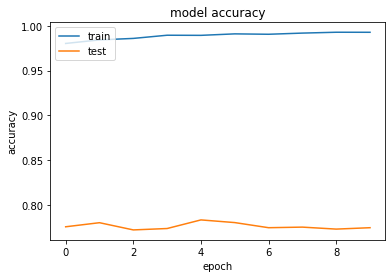

In [ ]:
plt.plot(m_h.history['accuracy'])
plt.plot(m_h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

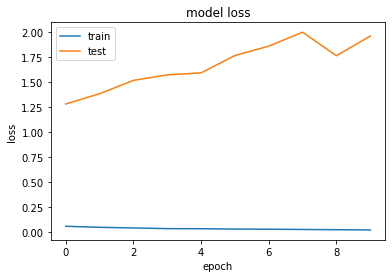

In [ ]:
# summarize history for loss
plt.plot(m_h.history['loss'])
plt.plot(m_h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Implementing Logistic Regression
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_data, Y_train_data)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train_data, Y_train_data) * 100, 2)
acc_log

79.25

In [ ]:
# Support Vector Machines
svc = SVC()
svc.fit(X_train_data, Y_train_data)
Y_predSVM = svc.predict(X_test)
acc_svc = round(svc.score(X_train_data, Y_train_data) * 100, 2)
acc_svc

80.36

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_data, Y_train_data)
Y_predKNN = knn.predict(X_test)
acc_knn = round(knn.score(X_train_data, Y_train_data) * 100, 2)
acc_knn

84.24

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train_data, Y_train_data)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train_data, Y_train_data) * 100, 2)
acc_gaussian

69.69

In [ ]:
# Linear SVC

linear_svc = LinearSVC(max_iter=10000)
linear_svc.fit(X_train_data, Y_train_data)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train_data, Y_train_data) * 100, 2)
acc_linear_svc

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


52.39

In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train_data, Y_train_data)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train_data, Y_train_data) * 100, 2)
acc_sgd

63.95

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Naive Bayes',  
              'Stochastic Gradient Decent', 'Linear SVC'],
    'Score': [acc_svc, acc_knn, acc_log, 
               acc_gaussian, 
              acc_sgd, acc_linear_svc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,KNN,84.24
0,Support Vector Machines,80.36
2,Logistic Regression,79.25
3,Naive Bayes,69.69
4,Stochastic Gradient Decent,63.95
5,Linear SVC,52.39


In [ ]:
#Plot the classification report
from sklearn.metrics import classification_report,confusion_matrix
Y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in Y_pred])
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      6115
           1       0.65      0.56      0.60      1588

    accuracy                           0.85      7703
   macro avg       0.77      0.74      0.75      7703
weighted avg       0.84      0.85      0.84      7703
 

